# Gather

This script is tranforming raw netcdf data into tiff files in the following steps:

1. Slicing the netcf into the correct time period needed for the event.
2. Analyzing the data to retrieve the maximum sea waterlevel and rainfall
3. Combining these results with a Digital Elevation Model from that specific area
4. Using the bathtub and hand method to create a tiff file.

In [2]:
import xarray as xr
import pandas as pd
import netCDF4
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pathlib
from IPython.display import HTML

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

#### User input

In [3]:
# Define the path to the data folder
base_path = "C:/Users/vries_cy/OneDrive - Stichting Deltares/Indonesia case for students"
data_path = "semarang/semarang_forcing/"

data_folder = pathlib.Path(base_path, data_path)


Creating a map visualization to look at the location

TODO: 
- tooltip
- multiple locations? 
- information about this location

In [4]:
biggest_event_date = "7-4-2012"     #"%d-%m-%Y"
event_windows = 2                   #before afterindays
station = 12932

target_date = datetime.strptime(biggest_event_date, "%d-%m-%Y")
# Define the sliding window
days_before = event_windows
days_after = event_windows
# Calculate the date range
start_date = target_date - timedelta(days=days_before)
end_date = target_date + timedelta(days=days_after)

# Retrieve the data
forcing_file = "waterlevel.nc"
waterlevel_data = pathlib.Path(data_folder, forcing_file)

fluvial_file = "precip_era5.nc"
fluvial_data = pathlib.Path(data_folder, fluvial_file)

In [27]:
def wgs84_to_web_mercator(lat, lon):
    print(lat, lon)

    k = 6378137
    x = lon * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k

    return x, y

TOOLTIPS = [('Station name: ', '@name')]

p = figure()

l1 = wgs84_to_web_mercator(-7.6, 109.5)
l2 = wgs84_to_web_mercator(-6.2, 111)

# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", y_axis_type="mercator", tooltips=TOOLTIPS, x_range=(l1[0], l2[0]), y_range=(l1[1], l2[1]))

p.add_tile("CartoDB Positron", retina=True)

waterlevel_ds = xr.open_dataset(waterlevel_data, engine="netcdf4")
x,y = wgs84_to_web_mercator(waterlevel_ds['station_y_coordinate'].values, waterlevel_ds['station_x_coordinate'].values)
p.circle(x, y)

fluvial_ds = xr.open_dataset(fluvial_data, engine="netcdf4")
print(fluvial_ds)
x,y = wgs84_to_web_mercator(fluvial_ds['y'].values, fluvial_ds['x'].values)
p.circle(x, y)

show(p)


-7.6 109.5
-6.2 111
[-6.929] [110.347]
<xarray.Dataset>
Dimensions:      (index: 1, time: 376944)
Coordinates:
    y            (index) float32 ...
    x            (index) float32 ...
  * time         (time) datetime64[ns] 1979-01-01 ... 2021-12-31T23:00:00
    spatial_ref  int32 ...
Dimensions without coordinates: index
Data variables:
    precip       (time, index) float32 ...
[-7.] [110.5]


# Coastal flood
The first step is to gain access to the waterlevel data.

TODO: make an assignment with this data. Threshold when it is flooded? 


In [6]:
forcing_file = "waterlevel_gtsm_dailymax.nc"
waterlevel_data = pathlib.Path(data_folder, forcing_file)

ds = xr.open_dataset(waterlevel_data, engine="netcdf4")
water_level_var = ds["waterlevel"]
water_level_df = water_level_var.to_dataframe().reset_index()

sliced_water_level_df = water_level_df[(water_level_df['time'] >= start_date) & (water_level_df['time'] <= end_date) & (water_level_df['stations'] == station)]
max_water_level = sliced_water_level_df['waterlevel'].max()


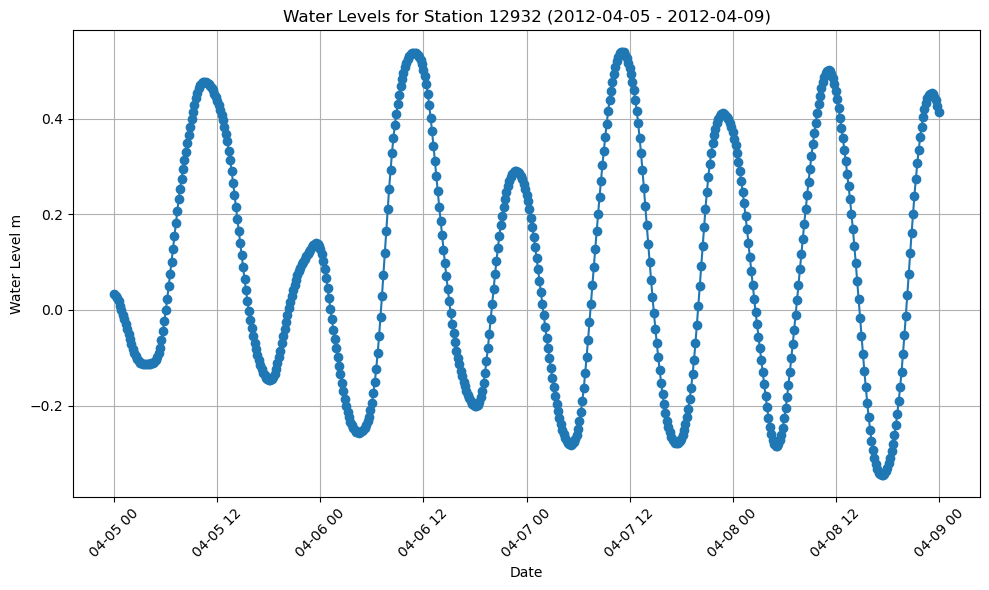

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_water_level_df['time'], sliced_water_level_df['waterlevel'], marker='o')
plt.title(f'Water Levels for Station {station} ({start_date.date()} - {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Water Level m')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Fluvial flood forcing

In [8]:
fluvial_file = "precip_era5.nc"
fluvial_data = pathlib.Path(data_folder, fluvial_file)

ds = xr.open_dataset(fluvial_data, engine="netcdf4")
precipitation_var = ds["precip"]
precipitation_df = precipitation_var.to_dataframe().reset_index()
precipitation_df2 = precipitation_df[precipitation_df["precip"] != 0]
precipitation_df2.dropna(subset=['precip'], inplace=True)
precipitation_df2.to_csv("pdata.csv", sep=';')


sliced_precipitation_df = precipitation_df[(precipitation_df['time'] >= start_date) & (precipitation_df['time'] <= end_date)]
total_precip = np.nanmean(sliced_precipitation_df["precip"])*sliced_precipitation_df.shape[0]/1000


C:\Users\vries_cy\AppData\Local\Temp\ipykernel_44576\2669890748.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation_df2.dropna(subset=['precip'], inplace=True)


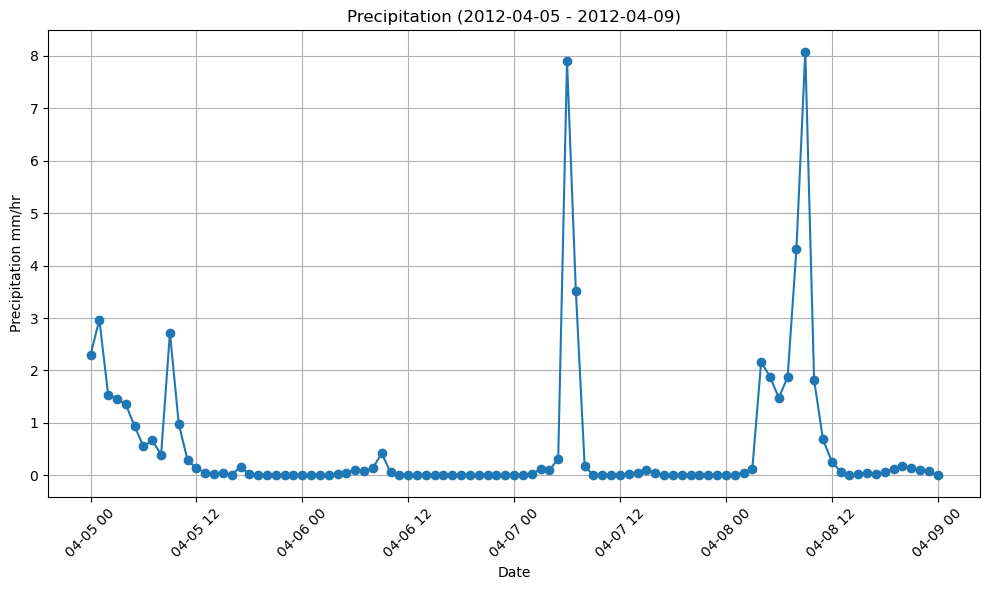

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_precipitation_df['time'], sliced_precipitation_df['precip'], marker='o')
plt.title(f'Precipitation ({start_date.date()} - {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Precipitation mm/hr')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


TODO: this code needs cleaning up
This code below is WIP to clean up the code in the cell below this.

In [22]:
total_precip = sliced_precipitation_df['precip'].sum()
# print(total_precip)
duration = 999999

for start_index in range(len(sliced_precipitation_df)):
    cum_precip = sliced_precipitation_df.iloc[start_index:]['precip'].cumsum()
    precip_threshold = np.where(cum_precip >= total_precip * 0.5 )[0]
    if len(precip_threshold) == 0:
        continue
    end_index = precip_threshold[0]
    if end_index < duration:
        duration = end_index
        best_start_time = pd.Timestamp(sliced_precipitation_df.iloc[start_index]['time'])
        best_end_time = pd.Timestamp(sliced_precipitation_df['time'].values[start_index + end_index])
        shortest_duration = best_end_time - best_start_time
    start_index += 1



C:\Users\vries_cy\AppData\Local\Temp\ipykernel_44576\1219814471.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  moving_start.set_data(start_time, sliced_precipitation_df.iloc[start_index]['precip'])


Start Time: 2012-04-07 06:00:00
End Time: 2012-04-08 09:00:00
Shortest Duration: 1 days 03:00:00
Max water level (m) during selected period is 0.5400000214576721
Total precipitation (m) during selected period is 53.57925796508789
Smallest percentage of time when rainfall volume reached 50% is 0.28125


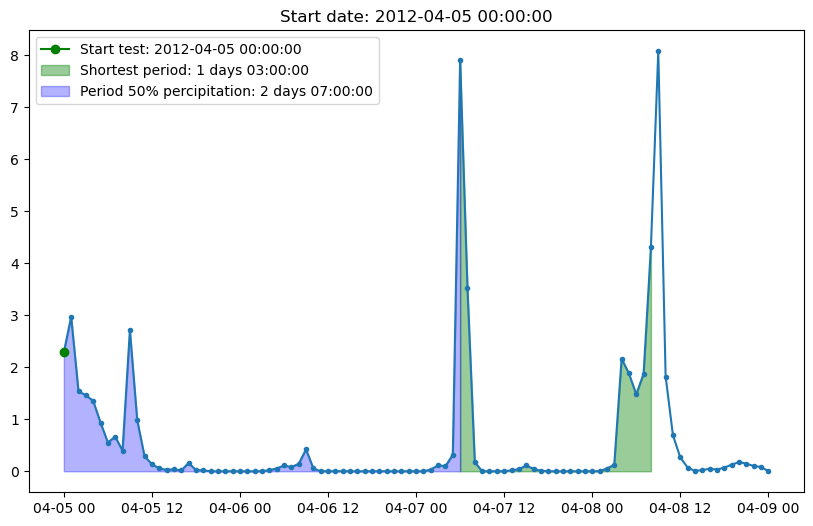

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((10, 6))
ax.set_title('test')
ax.plot(sliced_precipitation_df['time'], sliced_precipitation_df['precip'], marker='.')
moving_start, = ax.plot([], [], color='green', label='Start time', marker='o')
total_precip = sliced_precipitation_df['precip'].sum()
dynamic_fill = ax.fill_between([], [])
result_fill = ax.fill_between([], [])
duration = 999999

def animate(start_index):
    global duration, dynamic_fill, result_fill, shortest_duration
    start_time = pd.Timestamp(sliced_precipitation_df.iloc[start_index]['time'])
    ax.set_title(f"Start date: {start_time}")
    cum_precip = sliced_precipitation_df.iloc[start_index:]['precip'].cumsum()
    precip_threshold = np.where(cum_precip >= total_precip * 0.5 )[0]
    moving_start.set_data(start_time, sliced_precipitation_df.iloc[start_index]['precip'])
    moving_start.set_label(f"Start test: {start_time}")
    dynamic_fill.remove()
    if not len(precip_threshold) == 0:
        end_index = precip_threshold[0]
        x = sliced_precipitation_df.iloc[start_index: start_index + end_index]['time']
        y = sliced_precipitation_df.iloc[start_index: start_index + end_index]['precip']
        start_time = pd.Timestamp(sliced_precipitation_df.iloc[start_index]['time'])
        end_time = pd.Timestamp(sliced_precipitation_df['time'].values[start_index + end_index])
        dynamic_fill = ax.fill_between(x, y, color="blue", alpha=0.3)
        dynamic_fill.set_label(f"Period 50% percipitation: {end_time - start_time}")
        if end_index < duration:
            duration = end_index
            best_start_time = start_time
            best_end_time = end_time
            shortest_duration = best_end_time - best_start_time
            result_fill.remove()
            result_fill = ax.fill_between(x, y, color="green", alpha=0.4)
            result_fill.set_label(f"Shortest period: {shortest_duration}")
    else:
        x = sliced_precipitation_df.iloc[start_index: -1]['time']
        y = sliced_precipitation_df.iloc[start_index: -1]['precip']
        dynamic_fill = ax.fill_between(x, y, color="red", alpha=0.3)
    plt.legend()


animation = FuncAnimation(fig=fig, func=animate, frames=len(sliced_precipitation_df))

display(HTML(animation.to_jshtml()))

# Print the result
print(f"Start Time: {best_start_time}")
print(f"End Time: {best_end_time}")
print(f"Shortest Duration: {shortest_duration}")


#PRINT FLUVIAL AND COASTAL FORCING========================================
print(f"Max water level (m) during selected period is {max_water_level}")
print(f"Total precipitation (m) during selected period is {total_precip}")
print(f"Smallest percentage of time when rainfall volume reached 50% is {shortest_duration/timedelta(days=event_windows*2)}")